In [1]:
import pandas as pd

In [2]:
from backtesting import Strategy
from backtesting.lib import crossover

C:\Users\antho\Anaconda3\lib\site-packages\backtesting\_plotting.py:44: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from backtesting import Backtest

In [4]:
%matplotlib inline
import seaborn as sns
from Price_Data import hist_data

In [5]:
import matplotlib.pyplot as plt

In [6]:
btcusd = hist_data('Bitstamp')

C:\Users\antho\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
btcusd.columns = ['Open']

In [8]:
ss = btcusd.resample('H')

In [9]:
op = ss.first().ffill()
hi = ss.max().ffill()
lo = ss.min().ffill()
cl = ss.last().ffill()

In [10]:
btcusd

,Open
Date,
2011-09-13 13:53:36,5.80
2011-09-13 13:53:44,5.83
2011-09-13 13:53:49,5.90
2011-09-13 13:53:54,6.00
2011-09-13 14:32:53,5.95
...,...
2019-12-12 23:58:18,7184.44
2019-12-12 23:58:20,7184.44
2019-12-12 23:59:05,7190.53


In [11]:
ohlc = op
ohlc.columns = ['Open']
ohlc['High'] = hi
ohlc['Low'] = lo
ohlc['Close'] = cl
ohlc

,Open,High,Low,Close
Date,,,,
2011-09-13 13:00:00,5.80,6.00,5.80,6.00
2011-09-13 14:00:00,5.95,5.95,5.76,5.76
2011-09-13 15:00:00,5.65,5.65,5.65,5.65
2011-09-13 16:00:00,5.65,5.65,5.65,5.65
2011-09-13 17:00:00,5.65,5.65,5.65,5.65
...,...,...,...,...
2019-12-12 19:00:00,7205.66,7218.00,7186.36,7193.66
2019-12-12 20:00:00,7205.14,7250.23,7195.00,7242.49
2019-12-12 21:00:00,7245.85,7253.68,7180.83,7194.57


In [12]:
import datetime as dt

In [13]:
yr1 = ohlc.loc['2018-12-12':]
yr2 = ohlc.loc['2017-12-12':]
yr4 = ohlc.loc['2015-12-12':]

# 1 Year SMA and EMA

In [14]:
def SMA(values,n):
    return pd.Series(values).rolling(n).mean()

In [15]:
class SmaCross(Strategy):
    
    n1 = 37
    n2 = 73
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [16]:
def EMA(val,n):
    res = pd.Series(val).copy()
    return res.ewm(span=n,adjust=False).mean()

In [17]:
class EmaCross(Strategy):
    
    n1 = 901
    n2 = 931
    
    def init(self):
        # Precompute two moving averages
        self.ema1 = self.I(EMA, self.data.Close, self.n1)
        self.ema2 = self.I(EMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.ema2, self.ema1):
            self.sell()

In [18]:
def DEMA(val,n):
    exp1 = EMA(val,n)
    exp2 = EMA(exp1,n)
    return 2*exp1 - exp2

In [19]:
class DemaCross(Strategy):
    
    n1 = 681
    n2 = 981
    
    def init(self):
        # Precompute two moving averages
        self.dema1 = self.I(DEMA, self.data.Close, self.n1)
        self.dema2 = self.I(DEMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.dema1, self.dema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.dema2, self.dema1):
            self.sell()

In [20]:
import scipy.interpolate as interp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Strategies for different Time Horizons

In [21]:
def time_horiz(hist,ma):
    
    if ma == 'SMA':
        bt = Backtest(hist,SmaCross,cash=10000)
    elif ma == 'EMA':
        bt = Backtest(hist,EmaCross,cash=10000)
    elif ma == 'DEMA':
        bt = Backtest(hist,DemaCross,cash=10000)
    
    data, heat = bt.optimize('Sharpe Ratio',n1=range(1,200,9),n2=range(1,200,9),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

    heat.sort_values()
    hmap = heat.groupby(['n1','n2']).mean().unstack()
    hmap

    heat_pic = sns.heatmap(hmap, cmap='Spectral')
    
    tr = hmap.stack()

    n1 = [i[0] for i in tr.index]
    n2 = [i[1] for i in tr.index]

    val = []
    for (i,j) in zip(n1,n2):
        if i<j:
            val.append(tr.loc[i,j])

    px, py = np.meshgrid(np.linspace(np.min(n1),np.max(n1),100),np.linspace(np.min(n2),np.max(n2),100))
    pz = interp.griddata((n1,n2),val,(px,py),method='cubic')

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(px,py,pz,cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
    return data

# 1 Year SMA

In [21]:
bt = Backtest(yr1,SmaCross,cash=10000)
data, heat = bt.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [301]:
Backtest(yr1,SmaCross,cash=10000).run()

Start                     2018-12-12 00:00:00
End                       2019-12-12 23:00:00
Duration                    365 days 23:00:00
Exposure [%]                          75.2135
Equity Final [$]                      22791.9
Equity Peak [$]                       38472.5
Return [%]                            127.919
Buy & Hold Return [%]                 115.559
Max. Drawdown [%]                    -47.6137
Avg. Drawdown [%]                    -2.82744
Max. Drawdown Duration      169 days 04:00:00
Avg. Drawdown Duration        3 days 20:00:00
# Trades                                    9
Win Rate [%]                          22.2222
Best Trade [%]                        194.493
Worst Trade [%]                       -13.778
Avg. Trade [%]                        17.7553
Max. Trade Duration         154 days 12:00:00
Avg. Trade Duration          30 days 14:00:00
Expectancy [%]                        26.6279
SQN                                   0.48405
Sharpe Ratio                      

In [24]:
data

Start                         2018-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        365 days 23:00:00
Exposure [%]                              75.2135
Equity Final [$]                          30868.1
Equity Peak [$]                           38628.6
Return [%]                                208.681
Buy & Hold Return [%]                     115.559
Max. Drawdown [%]                        -40.2636
Avg. Drawdown [%]                        -2.66611
Max. Drawdown Duration          169 days 04:00:00
Avg. Drawdown Duration            3 days 18:00:00
# Trades                                        5
Win Rate [%]                                   40
Best Trade [%]                            205.001
Worst Trade [%]                          -10.2256
Avg. Trade [%]                            38.8915
Max. Trade Duration             154 days 13:00:00
Avg. Trade Duration              55 days 02:00:00
Expectancy [%]                            48.6797


In [22]:
heat.index.names = [r'Short (days)',r'Long (days)']

In [23]:
hh = heat*np.sqrt(12)

In [33]:
ax.get_xticks()

array([ 0.5, 40.5, 80.5])

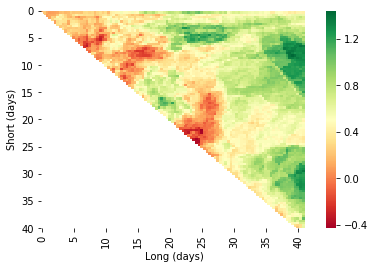

In [194]:
hh.sort_values()
hmap_sma = hh.groupby([r'Short (days)',r'Long (days)']).mean().unstack()
ax = sns.heatmap(hmap_sma,cmap='RdYlGn',xticklabels=list(range(0,101)),yticklabels=list(range(0,101)))
ax.set_xticks(ax.get_xticks()[::12])
ax.set_xticklabels(list(range(41))[::5])
ax.set_yticks(ax.get_yticks()[::12])
ax.set_yticklabels(list(range(0,41))[::5])
fig = ax.get_figure()

In [195]:
fig.tight_layout()
fig.savefig('btc_sma1_hmap.png')

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  from ipykernel import kernelapp as app
C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


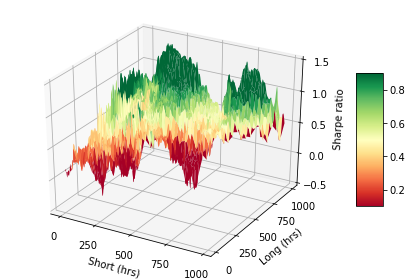

In [647]:
tr = hmap_sma.stack()
n1 = [i[0] for i in tr.index]
n2 = [i[1] for i in tr.index]

val = []
for (i,j) in zip(n1,n2):
    if i<j:
        val.append(tr.loc[i,j])

px, py = np.meshgrid(np.linspace(np.min(n1),np.max(n1),300),np.linspace(np.min(n2),np.max(n2),300))
pz = interp.griddata((n1,n2),val,(px,py),method='cubic')

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(px,py,pz,cmap='RdYlGn',vmin=0.1,vmax=0.9)
fig.colorbar(surf, shrink=0.5,aspect=5)
ax.set_xlabel(r'Short (hrs)')
ax.set_ylabel(r'Long (hrs)')
ax.set_zlabel('Sharpe ratio')
ax.set_zticks([-0.5,0,0.5,1,1.5])
ax.set_xticks([0,250,500,750,1000])
ax.set_yticks([0,250,500,750,1000])
plt.tight_layout()
plt.savefig('plt_sma.png')

In [122]:
rr = Backtest(yr1,SmaCross_opt,cash=10000).run()._trade_data
rr['P/L'].iloc[0] = 0
rr['P/L'].interpolate(method='time',inplace=True)

C:\Users\antho\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


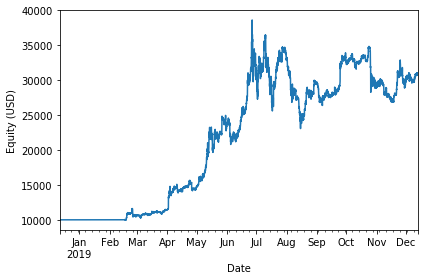

In [123]:
plt.xlabel('Date')
plt.ylabel(r'Equity (USD)')
fig = rr['Equity'].plot().get_figure()
fig.tight_layout()
fig.savefig('btc_sma1_equity.png')

# Price Data Plots

In [134]:
import yfinance as yf

In [135]:
sp_df = yf.download('^GSPC', 
                      start='2011-09-13', 
                      end='2019-12-13', 
                      progress=False,interval='1d')
sp = sp_df.iloc[:,:4]
sp

,Open,High,Low,Close
Date,,,,
2011-09-12,1153.500000,1162.520020,1136.069946,1162.270020
2011-09-13,1162.589966,1176.410034,1157.439941,1172.869995
2011-09-14,1173.319946,1202.380005,1162.729980,1188.680054
2011-09-15,1189.439941,1209.109985,1189.439941,1209.109985
2011-09-16,1209.209961,1220.060059,1204.459961,1216.010010
...,...,...,...,...
2019-12-06,3134.620117,3150.600098,3134.620117,3145.909912
2019-12-09,3141.860107,3148.870117,3135.459961,3135.959961
2019-12-10,3135.360107,3142.120117,3126.090088,3132.520020


In [136]:
sp1 = sp.loc['2018-12-12':]
sp2 = sp.loc['2017-12-12':]
sp4 = sp.loc['2015-12-12':]

In [137]:
class SmaCross_alt(Strategy):
    
    n1 = 40
    n2 = 43
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [138]:
sp_run = Backtest(sp1,SmaCross_alt,cash=10000).run()
val = sp_run._trade_data

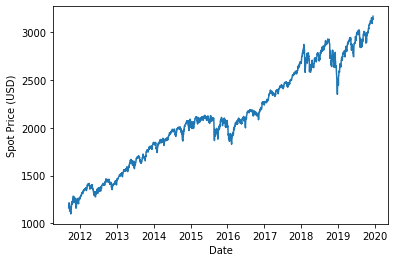

In [670]:
plt.plot(sp['Close'])
plt.xlabel('Date')
plt.ylabel('Spot Price (USD)')
plt.tight_layout
plt.savefig('sp_price_plt.png')

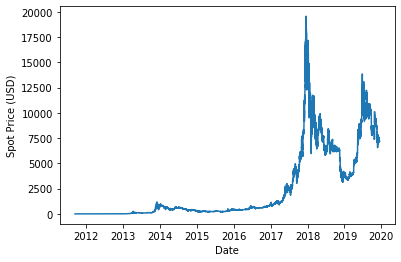

In [101]:
plt.plot(ohlc['Close'])
plt.xlabel('Date')
plt.ylabel('Spot Price (USD)')
plt.tight_layout
plt.savefig('btc_price_plt.png')

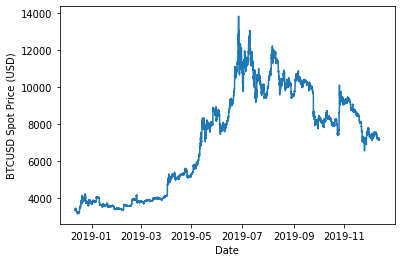

In [115]:
plt.plot(yr1['Close'])
plt.xlabel('Date')
plt.ylabel('BTCUSD Spot Price (USD)')
plt.tight_layout
plt.savefig('btc_yr1_p.png')

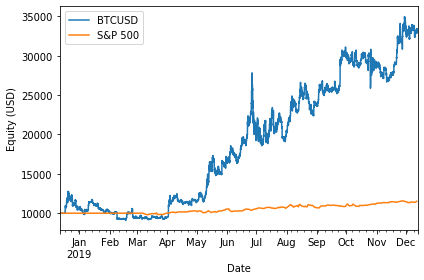

In [170]:
rr['Equity'].plot(label='BTCUSD')
val['Equity'].plot(label=r'S&P 500')
plt.ylabel(r'Equity (USD)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('equity.png')

# Traditional Windows

In [680]:
Backtest(yr1,SmaCross,cash=10000).optimize('Sharpe Ratio', n1=240,n2=960)

Start                         2018-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        365 days 23:00:00
Exposure [%]                              75.0655
Equity Final [$]                          22771.1
Equity Peak [$]                           38457.8
Return [%]                                127.711
Buy & Hold Return [%]                     115.559
Max. Drawdown [%]                        -47.2702
Avg. Drawdown [%]                        -2.88848
Max. Drawdown Duration          169 days 04:00:00
Avg. Drawdown Duration            3 days 22:00:00
# Trades                                        5
Win Rate [%]                                   40
Best Trade [%]                            192.339
Worst Trade [%]                          -14.4114
Avg. Trade [%]                            31.7686
Max. Trade Duration             154 days 13:00:00
Avg. Trade Duration              54 days 23:00:00
Expectancy [%]                            47.5369


In [682]:
Backtest(yr1,EmaCross,cash=10000).optimize('Sharpe Ratio', n1=240,n2=960)

Start                         2018-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        365 days 23:00:00
Exposure [%]                              91.6316
Equity Final [$]                          22470.2
Equity Peak [$]                           32104.5
Return [%]                                124.702
Buy & Hold Return [%]                     115.559
Max. Drawdown [%]                        -42.7587
Avg. Drawdown [%]                        -3.30985
Max. Drawdown Duration          169 days 04:00:00
Avg. Drawdown Duration            4 days 22:00:00
# Trades                                       10
Win Rate [%]                                   30
Best Trade [%]                            177.575
Worst Trade [%]                          -11.1402
Avg. Trade [%]                            14.3143
Max. Trade Duration             158 days 20:00:00
Avg. Trade Duration              33 days 13:00:00
Expectancy [%]                            22.6938


In [681]:
Backtest(yr1,DemaCross,cash=10000).optimize('Sharpe Ratio', n1=240,n2=960)

Start                          2018-12-12 00:00:00
End                            2019-12-12 23:00:00
Duration                         365 days 23:00:00
Exposure [%]                               99.1916
Equity Final [$]                           6980.16
Equity Peak [$]                            16597.6
Return [%]                                -30.1984
Buy & Hold Return [%]                      115.559
Max. Drawdown [%]                         -60.8961
Avg. Drawdown [%]                         -6.81581
Max. Drawdown Duration           169 days 04:00:00
Avg. Drawdown Duration            10 days 02:00:00
# Trades                                        28
Win Rate [%]                               32.1429
Best Trade [%]                             36.7046
Worst Trade [%]                           -23.4185
Avg. Trade [%]                           -0.431969
Max. Trade Duration               30 days 14:00:00
Avg. Trade Duration               13 days 00:00:00
Expectancy [%]                 

In [687]:
Backtest(sp1,SmaCross,cash=10000).optimize('Sharpe Ratio', n1=10,n2=40)

Start                       2018-12-12 00:00:00
End                         2019-12-12 00:00:00
Duration                      365 days 00:00:00
Exposure [%]                            42.4658
Equity Final [$]                        9295.34
Equity Peak [$]                         10389.9
Return [%]                             -7.04655
Buy & Hold Return [%]                   19.5204
Max. Drawdown [%]                      -15.6841
Avg. Drawdown [%]                      -3.51493
Max. Drawdown Duration        192 days 00:00:00
Avg. Drawdown Duration         42 days 00:00:00
# Trades                                      5
Win Rate [%]                                  0
Best Trade [%]                        -0.831725
Worst Trade [%]                        -3.95435
Avg. Trade [%]                          -2.5557
Max. Trade Duration            50 days 00:00:00
Avg. Trade Duration            31 days 00:00:00
Expectancy [%]                              NaN
SQN                                    -

In [688]:
Backtest(sp1,EmaCross,cash=10000).optimize('Sharpe Ratio', n1=10,n2=40)

Start                       2018-12-12 00:00:00
End                         2019-12-12 00:00:00
Duration                      365 days 00:00:00
Exposure [%]                            74.5205
Equity Final [$]                        10325.4
Equity Peak [$]                         11357.9
Return [%]                              3.25381
Buy & Hold Return [%]                   19.5204
Max. Drawdown [%]                      -14.4039
Avg. Drawdown [%]                      -2.01392
Max. Drawdown Duration        192 days 00:00:00
Avg. Drawdown Duration         22 days 00:00:00
# Trades                                      6
Win Rate [%]                            16.6667
Best Trade [%]                          9.28466
Worst Trade [%]                        -4.58049
Avg. Trade [%]                        -0.365655
Max. Trade Duration           124 days 00:00:00
Avg. Trade Duration            46 days 00:00:00
Expectancy [%]                          3.46054
SQN                                   -0

In [692]:
0.451627*np.sqrt(12)

1.5644818201398185

In [689]:
Backtest(sp1,DemaCross,cash=10000).optimize('Sharpe Ratio', n1=10,n2=40)

Start                        2018-12-12 00:00:00
End                          2019-12-12 00:00:00
Duration                       365 days 00:00:00
Exposure [%]                              90.411
Equity Final [$]                         11174.8
Equity Peak [$]                          11479.8
Return [%]                               11.7481
Buy & Hold Return [%]                    19.5204
Max. Drawdown [%]                       -7.61072
Avg. Drawdown [%]                       -2.00701
Max. Drawdown Duration          94 days 00:00:00
Avg. Drawdown Duration          20 days 00:00:00
# Trades                                      11
Win Rate [%]                             72.7273
Best Trade [%]                           5.83336
Worst Trade [%]                         -2.94279
Avg. Trade [%]                           1.19059
Max. Trade Duration             58 days 00:00:00
Avg. Trade Duration             30 days 00:00:00
Expectancy [%]                            2.1725
SQN                 

# PnL Plots

In [161]:
class SmaCross_trad(Strategy):
    
    n1 = 1
    n2 = 21
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [76]:
alt_max = Backtest(yr1,SmaCross_alt,cash=10000).run()._trade_data
alt_max['P/L'].iloc[0] = 0
alt_max = alt_max['P/L'].interpolate(method='time')

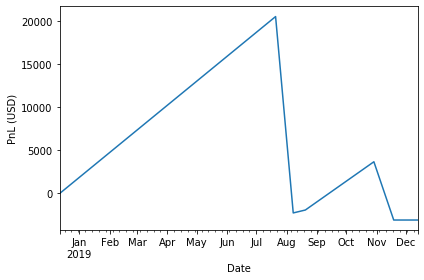

In [133]:
plt.xlabel('Date')
plt.ylabel(r'PnL (USD)')
rr = Backtest(yr1,SmaCross_opt,cash=10000).run()._trade_data
rr['P/L'].iloc[0] = 0
rr = rr['P/L'].interpolate(method='time')
fig = rr.plot().get_figure()
fig.tight_layout()
fig.savefig('btc_sma1_pl.png')

# Correlation Analysis

In [147]:
rr = Backtest(yr1,SmaCross_opt,cash=10000).run()._trade_data
ap = rr['P/L']
bp = val['P/L']
bp[0] = 0
ap[0] = 0

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [148]:
bp.interpolate(method='time',inplace=True)
ap.interpolate(method='time',inplace=True)

In [149]:
ap = ap.asfreq('D')

In [195]:
bp = bp.asfreq('D').interpolate(method='time')
bp.rolling(20).corr(ap).dropna().plot()
plt.ylabel('Correlation')
plt.tight_layout()

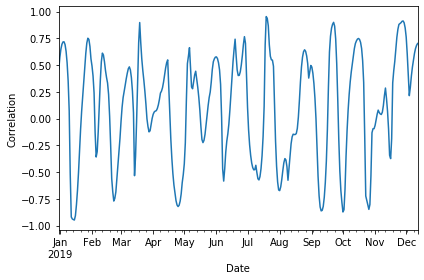

In [234]:
bp.rolling(20).corr(ap).dropna().plot()
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('cor_sma1.png')

In [144]:
sp1_close = sp1['Close']
btc1_close = yr1['Close']

In [161]:
btc1_close = btc1_close.asfreq('D')
sp1_close = sp1_close.asfreq('D')
sp1_close.interpolate(method='time',inplace=True)

In [142]:
import matplotlib.dates as mdates

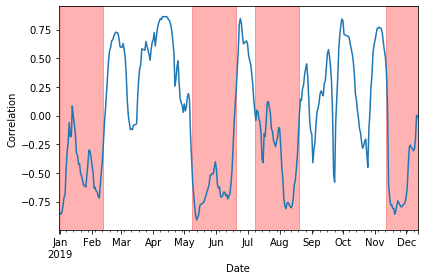

In [516]:
btc1_close.rolling(20).corr(sp1_close).dropna().plot()
plt.ylabel('Correlation')
plt.axvspan(dt.datetime(2019,5,8),dt.datetime(2019,6,20), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,1,1),dt.datetime(2019,2,12), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,7,8),dt.datetime(2019,8,20), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,11,12),dt.datetime(2019,12,12), color='r', alpha=0.3)
plt.tight_layout()
plt.savefig('cor_price.png')

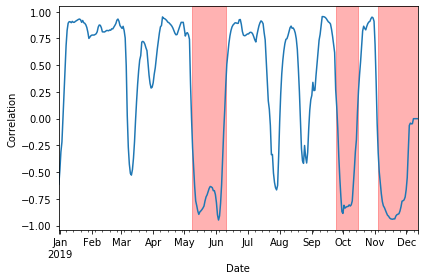

In [187]:
ap.rolling(20).corr(sp1_close).dropna().plot()
plt.ylabel('Correlation')
plt.axvspan(dt.datetime(2019,5,8),dt.datetime(2019,6,10), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,9,24),dt.datetime(2019,10,16), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,11,4),dt.datetime(2019,12,12), color='r', alpha=0.3)
plt.tight_layout()
plt.savefig('sp_close_sma1_corr.png')

# Evolving Sharpe Ratio

In [325]:
y1 = ohlc.loc['2018-12-12':]
y2 = ohlc.loc['2017-12-12':'2018-12-12']
y3 = ohlc.loc['2016-12-12':'2017-12-12']
y4 = ohlc.loc['2015-12-12':'2016-12-12']
y5 = ohlc.loc['2014-12-12':'2015-12-12']
y6 = ohlc.loc['2013-12-12':'2014-12-12']
y7 = ohlc.loc['2012-12-12':'2013-12-12']
y8 = ohlc.loc['2011-12-12':'2012-12-12']

## SMA

In [326]:
sma = Backtest(y1,SmaCross,cash=10000)

In [327]:
s1 = sma.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 4950 configurations.
  """Entry point for launching an IPython kernel.


In [329]:
sma = Backtest(y2,SmaCross,cash=10000)

In [330]:
s2 = sma.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 4950 configurations.
  """Entry point for launching an IPython kernel.


In [331]:
sma = Backtest(y3,SmaCross,cash=10000)

In [332]:
s3 = sma.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 4950 configurations.
  """Entry point for launching an IPython kernel.


In [333]:
sma = Backtest(y4,SmaCross,cash=10000)

In [334]:
s4 = sma.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 4950 configurations.
  """Entry point for launching an IPython kernel.


In [335]:
sma = Backtest(y5,SmaCross,cash=10000)

In [336]:
s5 = sma.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 4950 configurations.
  """Entry point for launching an IPython kernel.


In [337]:
sma = Backtest(y6,SmaCross,cash=10000)
s6 = sma.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [338]:
sma = Backtest(y7,SmaCross,cash=10000)
s7 = sma.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [339]:
sma = Backtest(y8,SmaCross,cash=10000)
s8 = sma.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [342]:
ema = Backtest(y2,EmaCross,cash=10000)
e2 = ema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [343]:
ema = Backtest(y3,EmaCross,cash=10000)
e3 = ema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [344]:
ema = Backtest(y4,EmaCross,cash=10000)
e4 = ema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [345]:
ema = Backtest(y5,EmaCross,cash=10000)
e5 = ema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [346]:
ema = Backtest(y6,EmaCross,cash=10000)
e6 = ema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [347]:
ema = Backtest(y7,EmaCross,cash=10000)
e7 = ema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [348]:
ema = Backtest(y8,EmaCross,cash=10000)
e8 = ema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [350]:
dema = Backtest(y2,DemaCross,cash=10000)
d2 = dema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [356]:
dema = Backtest(y3,DemaCross,cash=10000)
d3 = dema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [351]:
dema = Backtest(y4,DemaCross,cash=10000)
d4 = dema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [352]:
dema = Backtest(y5,DemaCross,cash=10000)
d5 = dema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [353]:
dema = Backtest(y6,DemaCross,cash=10000)
d6 = dema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [354]:
dema = Backtest(y7,DemaCross,cash=10000)
d7 = dema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [355]:
dema = Backtest(y8,DemaCross,cash=10000)
d8 = dema.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [385]:
d8

Start                          2011-12-12 00:00:00
End                            2012-12-12 23:00:00
Duration                         366 days 23:00:00
Exposure [%]                               81.3784
Equity Final [$]                           23782.9
Equity Peak [$]                            33916.9
Return [%]                                 137.829
Buy & Hold Return [%]                      312.538
Max. Drawdown [%]                         -48.2072
Avg. Drawdown [%]                         -3.77824
Max. Drawdown Duration           117 days 06:00:00
Avg. Drawdown Duration             4 days 07:00:00
# Trades                                         3
Win Rate [%]                               66.6667
Best Trade [%]                              115.46
Worst Trade [%]                           -12.1818
Avg. Trade [%]                             39.3787
Max. Trade Duration              131 days 11:00:00
Avg. Trade Duration               99 days 13:00:00
Expectancy [%]                 

In [391]:
from dateutil.relativedelta import relativedelta as rd

In [397]:
start = s1['Start']
times_arr = [start]

for i in range(1,8):
    times_arr.append(start-rd(years=i))
    
times_arr

[Timestamp('2018-12-12 00:00:00'),
 Timestamp('2017-12-12 00:00:00'),
 Timestamp('2016-12-12 00:00:00'),
 Timestamp('2015-12-12 00:00:00'),
 Timestamp('2014-12-12 00:00:00'),
 Timestamp('2013-12-12 00:00:00'),
 Timestamp('2012-12-12 00:00:00'),
 Timestamp('2011-12-12 00:00:00')]

In [412]:
sma_s = [201,441,251,311,151,361,831,211]
sma_l = [951,521,481,991,861,991,991,541]

In [443]:
ema_s = [901,101,821,881,421,541,161,521]
ema_l = [931,211,951,961,791,831,931,681]

In [415]:
dema_s = [681,131,421,921,401,331,531,981]
dema_l = [981,701,461,951,571,341,661,991]

In [542]:
for i in [sma_s,sma_l,ema_s,ema_l,dema_s,dema_l]:
    print(np.mean(i))

344.75
791.0
543.5
786.0
549.75
707.25


In [551]:
q1 = pd.Series(sma_s)
q2 = pd.Series(sma_l)
q1.corr(q2)

0.2631158699008671

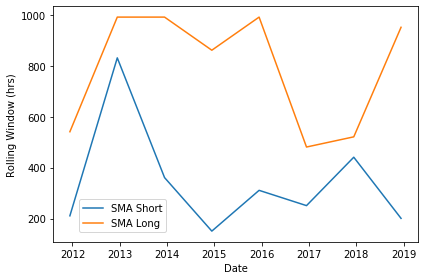

In [478]:
plt.plot(times_arr,sma_s,label='SMA Short')
plt.plot(times_arr,sma_l, label = 'SMA Long')
plt.xlabel('Date')
plt.ylabel(r'Rolling Window (hrs)')
plt.legend(loc=(0.07,0.04))
plt.tight_layout()
plt.savefig('sma_rol.png')

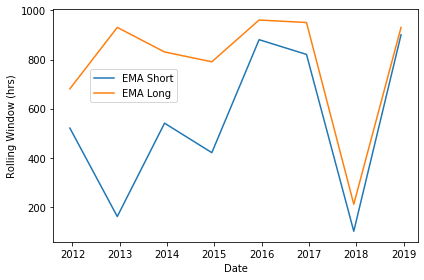

In [479]:
plt.plot(times_arr,ema_s,label='EMA Short')
plt.plot(times_arr,ema_l,label='EMA Long')
plt.xlabel('Date')
plt.ylabel(r'Rolling Window (hrs)')
plt.legend(loc=(0.1,0.6))
plt.tight_layout()
plt.savefig('ema_rol.png')

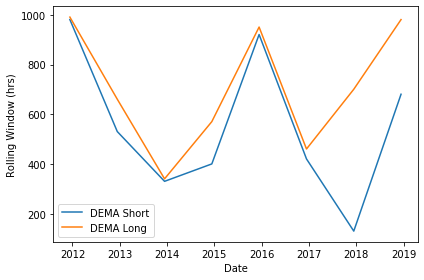

In [480]:
plt.plot(times_arr,dema_s,label='DEMA Short')
plt.plot(times_arr,dema_l, label='DEMA Long')
plt.xlabel('Date')
plt.ylabel(r'Rolling Window (hrs)')
plt.legend()
plt.tight_layout()
plt.savefig('dema_rol.png')

# Cumulative PnL

In [108]:
class SmaCross_opt(Strategy):
    
    n1 = 201
    n2 = 951
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [50]:
class EmaCross_opt(Strategy):
    
    n1 = 901
    n2 = 931
    
    def init(self):
        # Precompute two moving averages
        self.ema1 = self.I(EMA, self.data.Close, self.n1)
        self.ema2 = self.I(EMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.ema2, self.ema1):
            self.sell()

In [52]:
class DemaCross_opt(Strategy):
    
    n1 = 681
    n2 = 981
    
    def init(self):
        # Precompute two moving averages
        self.dema1 = self.I(DEMA, self.data.Close, self.n1)
        self.dema2 = self.I(DEMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.dema1, self.dema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.dema2, self.dema1):
            self.sell()

In [124]:
spl = Backtest(yr1,SmaCross_opt,cash=10000).run()._trade_data

In [125]:
spl = spl['P/L']

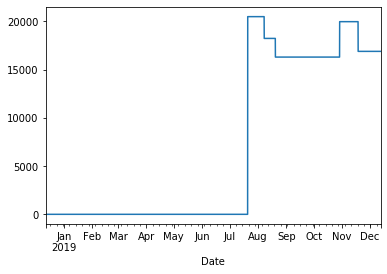

In [126]:
spl.fillna(0).cumsum().plot()

In [127]:
epl = Backtest(yr1,EmaCross_opt,cash=10000).run()._trade_data
dpl = Backtest(yr1,DemaCross_opt,cash=10000).run()._trade_data

In [128]:
epl = epl['P/L']
dpl = dpl['P/L']

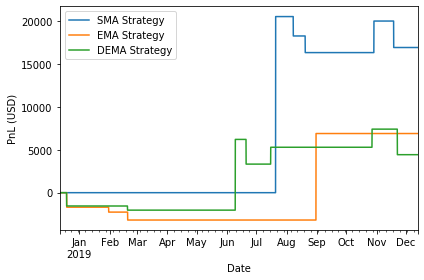

In [129]:
spl.fillna(0).cumsum().plot(label = 'SMA Strategy')
epl.fillna(0).cumsum().plot(label = 'EMA Strategy')
dpl.fillna(0).cumsum().plot(label = 'DEMA Strategy')
plt.ylabel(r'PnL (USD)')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig('cum_pnl.png')

# 1 Year EMA

In [188]:
ema1 = Backtest(yr1,EmaCross,cash=10000)
d_ema1, heat_ema = ema1.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [196]:
d_ema1

Start                         2018-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        365 days 23:00:00
Exposure [%]                                70.83
Equity Final [$]                          21111.5
Equity Peak [$]                           24359.2
Return [%]                                111.115
Buy & Hold Return [%]                     115.559
Max. Drawdown [%]                        -40.0853
Avg. Drawdown [%]                        -3.63971
Max. Drawdown Duration          169 days 04:00:00
Avg. Drawdown Duration            6 days 20:00:00
# Trades                                        4
Win Rate [%]                                   25
Best Trade [%]                            147.539
Worst Trade [%]                          -16.8153
Avg. Trade [%]                            28.0068
Max. Trade Duration             192 days 14:00:00
Avg. Trade Duration              64 days 20:00:00
Expectancy [%]                            45.7629


In [210]:
heat_ema.index.names = [r'Short (days)',r'Long (days)']
hh_ema = heat_ema*np.sqrt(12)

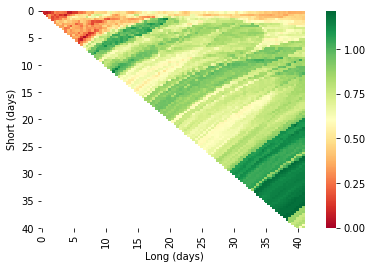

In [211]:
hh_ema.sort_values()
hmap_ema = hh_ema.groupby([r'Short (days)',r'Long (days)']).mean().unstack()
ax = sns.heatmap(hmap_ema,cmap='RdYlGn',xticklabels=list(range(0,101)),yticklabels=list(range(0,101)))
ax.set_xticks(ax.get_xticks()[::12])
ax.set_xticklabels(list(range(0,41))[::5])
ax.set_yticks(ax.get_yticks()[::12])
ax.set_yticklabels(list(range(0,41))[::5])
fig = ax.get_figure()

In [212]:
fig.tight_layout()
fig.savefig('btc_ema_hmap.png')

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  from ipykernel import kernelapp as app


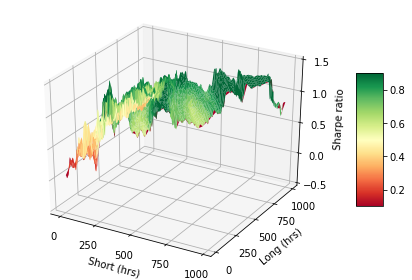

In [651]:
tr = hmap_ema.stack()
n1 = [i[0] for i in tr.index]
n2 = [i[1] for i in tr.index]

val = []
for (i,j) in zip(n1,n2):
    if i<j:
        val.append(tr.loc[i,j])

px, py = np.meshgrid(np.linspace(np.min(n1),np.max(n1),300),np.linspace(np.min(n2),np.max(n2),300))
pz = interp.griddata((n1,n2),val,(px,py),method='cubic')

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(px,py,pz,cmap='RdYlGn',vmin=0.1,vmax=0.9)
fig.colorbar(surf, shrink=0.5,aspect=5)
ax.set_xlabel(r'Short (hrs)')
ax.set_ylabel(r'Long (hrs)')
ax.set_zlabel('Sharpe ratio')
ax.set_zticks([-0.5,0,0.5,1,1.5])
ax.set_xticks([0,250,500,750,1000])
ax.set_yticks([0,250,500,750,1000])
plt.tight_layout()
plt.savefig('plt_ema.png')

# 1 Year DEMA

In [201]:
dema1 = Backtest(yr1,DemaCross,cash=10000)
d_dema1, heat_dema = dema1.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


KeyboardInterrupt: 

In [202]:
d_dema1

Start                          2018-12-12 00:00:00
End                            2019-12-12 23:00:00
Duration                         365 days 23:00:00
Exposure [%]                               93.5785
Equity Final [$]                           15220.1
Equity Peak [$]                            19982.8
Return [%]                                 52.2006
Buy & Hold Return [%]                      115.559
Max. Drawdown [%]                         -34.5335
Avg. Drawdown [%]                         -4.55732
Max. Drawdown Duration           118 days 20:00:00
Avg. Drawdown Duration             7 days 06:00:00
# Trades                                         8
Win Rate [%]                                  37.5
Best Trade [%]                             102.946
Worst Trade [%]                           -17.4796
Avg. Trade [%]                             9.44194
Max. Trade Duration              110 days 05:00:00
Avg. Trade Duration               42 days 20:00:00
Expectancy [%]                 

In [213]:
heat_dema.index.names = [r'Short (days)',r'Long (days)']
hh_dema = heat_dema*np.sqrt(12)

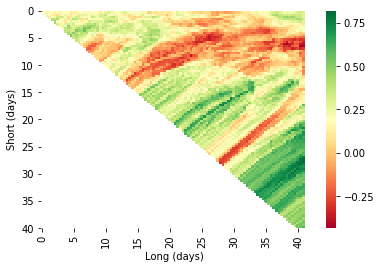

In [214]:
hh_dema.sort_values()
hmap_dema = hh_dema.groupby([r'Short (days)',r'Long (days)']).mean().unstack()
ax = sns.heatmap(hmap_dema,cmap='RdYlGn',xticklabels=list(range(0,101)),yticklabels=list(range(0,101)))
ax.set_xticks(ax.get_xticks()[::12])
ax.set_xticklabels(list(range(0,41))[::5])
ax.set_yticks(ax.get_yticks()[::12])
ax.set_yticklabels(list(range(0,41))[::5])
fig = ax.get_figure()

In [215]:
fig.tight_layout()
fig.savefig('btc_dema_hmap.png')

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  from ipykernel import kernelapp as app


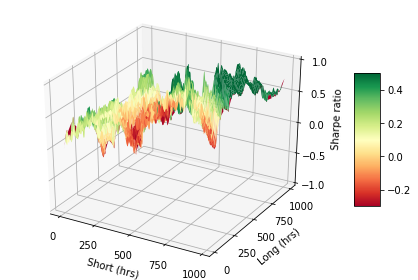

In [656]:
tr = hmap_dema.stack()
n1 = [i[0] for i in tr.index]
n2 = [i[1] for i in tr.index]

val = []
for (i,j) in zip(n1,n2):
    if i<j:
        val.append(tr.loc[i,j])

px, py = np.meshgrid(np.linspace(np.min(n1),np.max(n1),300),np.linspace(np.min(n2),np.max(n2),300))
pz = interp.griddata((n1,n2),val,(px,py),method='cubic')

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(px,py,pz,cmap='RdYlGn',vmin=-0.3,vmax=0.5)
fig.colorbar(surf, shrink=0.5,aspect=5)
ax.set_xlabel(r'Short (hrs)')
ax.set_ylabel(r'Long (hrs)')
ax.set_zlabel('Sharpe ratio')
ax.set_zticks([-1,-0.5,0,0.5,1])
ax.set_xticks([0,250,500,750,1000])
ax.set_yticks([0,250,500,750,1000])
plt.tight_layout()
plt.savefig('plt_dema.png')

# 2 Year SMA

In [554]:
sma2 = Backtest(yr2,SmaCross,cash=10000)
d_sma2, heat_sma2 = sma2.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [555]:
d_sma2

Start                         2017-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        730 days 23:00:00
Exposure [%]                              95.7932
Equity Final [$]                          71953.6
Equity Peak [$]                           75606.1
Return [%]                                619.536
Buy & Hold Return [%]                      56.235
Max. Drawdown [%]                         -49.197
Avg. Drawdown [%]                        -3.32021
Max. Drawdown Duration          291 days 14:00:00
Avg. Drawdown Duration            5 days 06:00:00
# Trades                                       46
Win Rate [%]                              63.0435
Best Trade [%]                            59.3385
Worst Trade [%]                          -20.4841
Avg. Trade [%]                            5.17005
Max. Trade Duration              56 days 07:00:00
Avg. Trade Duration              15 days 06:00:00
Expectancy [%]                            9.47821


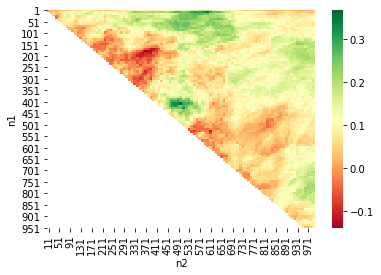

In [119]:
heat_sma2.sort_values()
hmap_sma2 = heat_sma2.groupby(['n1','n2']).mean().unstack()
sns.heatmap(hmap_sma2,cmap='RdYlGn')

# 2 Year EMA

In [556]:
ema2 = Backtest(yr2,EmaCross,cash=10000)
d_ema2, heat_ema2 = ema2.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [557]:
d_ema2

Start                         2017-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        730 days 23:00:00
Exposure [%]                              85.5726
Equity Final [$]                          34058.3
Equity Peak [$]                           39893.2
Return [%]                                240.583
Buy & Hold Return [%]                      56.235
Max. Drawdown [%]                         -55.688
Avg. Drawdown [%]                        -4.03157
Max. Drawdown Duration          282 days 08:00:00
Avg. Drawdown Duration            8 days 07:00:00
# Trades                                        8
Win Rate [%]                                   50
Best Trade [%]                            151.235
Worst Trade [%]                          -26.8169
Avg. Trade [%]                            21.9396
Max. Trade Duration             197 days 15:00:00
Avg. Trade Duration              78 days 05:00:00
Expectancy [%]                            34.3974


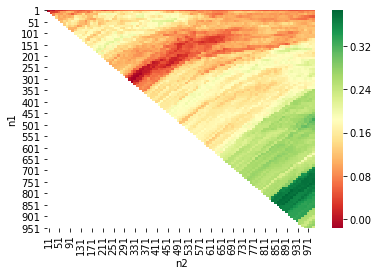

In [121]:
heat_ema2.sort_values()
hmap_ema2 = heat_ema2.groupby(['n1','n2']).mean().unstack()
sns.heatmap(hmap_ema2,cmap='RdYlGn')

# 2 Year DEMA

In [558]:
dema2 = Backtest(yr2,DemaCross,cash=10000)
d_dema2, heat_dema2 = dema2.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [559]:
d_dema2

Start                         2017-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                        730 days 23:00:00
Exposure [%]                              99.7606
Equity Final [$]                          35169.8
Equity Peak [$]                           65792.4
Return [%]                                251.698
Buy & Hold Return [%]                      56.235
Max. Drawdown [%]                        -51.6979
Avg. Drawdown [%]                        -4.08356
Max. Drawdown Duration          169 days 04:00:00
Avg. Drawdown Duration            5 days 16:00:00
# Trades                                       54
Win Rate [%]                               37.037
Best Trade [%]                            48.6487
Worst Trade [%]                          -15.7122
Avg. Trade [%]                            3.12492
Max. Trade Duration              98 days 14:00:00
Avg. Trade Duration              13 days 13:00:00
Expectancy [%]                            8.94743


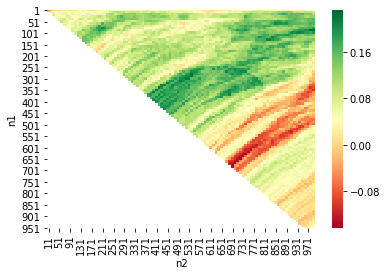

In [123]:
heat_dema2.sort_values()
hmap_dema2 = heat_dema2.groupby(['n1','n2']).mean().unstack()
sns.heatmap(hmap_dema2,cmap='RdYlGn')

# 4 Year SMA

In [560]:
sma4 = Backtest(yr4,SmaCross,cash=10000)
d_sma4, heat_sma4 = sma4.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [570]:
d_sma4

Start                         2015-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                       1461 days 23:00:00
Exposure [%]                              93.6472
Equity Final [$]                           290188
Equity Peak [$]                            474727
Return [%]                                2801.88
Buy & Hold Return [%]                     1480.12
Max. Drawdown [%]                        -56.3849
Avg. Drawdown [%]                        -3.61763
Max. Drawdown Duration          431 days 21:00:00
Avg. Drawdown Duration            5 days 07:00:00
# Trades                                       29
Win Rate [%]                              41.3793
Best Trade [%]                            244.526
Worst Trade [%]                          -21.2124
Avg. Trade [%]                            20.6084
Max. Trade Duration             154 days 19:00:00
Avg. Trade Duration              47 days 06:00:00
Expectancy [%]                            32.3589


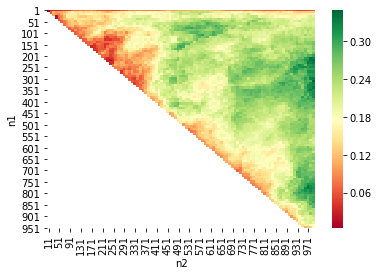

In [127]:
heat_sma4.sort_values()
hmap_sma4 = heat_sma4.groupby(['n1','n2']).mean().unstack()
sns.heatmap(hmap_sma4,cmap='RdYlGn')

# 4 Year EMA

In [562]:
ema4 = Backtest(yr4,EmaCross,cash=10000)
d_ema4, heat_ema4 = ema4.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [571]:
d_ema4

Start                         2015-12-12 00:00:00
End                           2019-12-12 23:00:00
Duration                       1461 days 23:00:00
Exposure [%]                              92.7324
Equity Final [$]                           310493
Equity Peak [$]                            351287
Return [%]                                3004.93
Buy & Hold Return [%]                     1480.12
Max. Drawdown [%]                        -72.0339
Avg. Drawdown [%]                         -3.5035
Max. Drawdown Duration          551 days 12:00:00
Avg. Drawdown Duration            6 days 07:00:00
# Trades                                       16
Win Rate [%]                                56.25
Best Trade [%]                            294.805
Worst Trade [%]                          -25.2862
Avg. Trade [%]                            37.3757
Max. Trade Duration             191 days 20:00:00
Avg. Trade Duration              84 days 18:00:00
Expectancy [%]                            49.5855


# 4 Year DEMA

In [563]:
dema4 = Backtest(yr4,DemaCross,cash=10000)
d_dema4, heat_dema4 = dema4.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [572]:
d_dema4

Start                          2015-12-12 00:00:00
End                            2019-12-12 23:00:00
Duration                        1461 days 23:00:00
Exposure [%]                                98.213
Equity Final [$]                            200754
Equity Peak [$]                             227967
Return [%]                                 1907.54
Buy & Hold Return [%]                      1480.12
Max. Drawdown [%]                         -51.1232
Avg. Drawdown [%]                         -3.81389
Max. Drawdown Duration           251 days 00:00:00
Avg. Drawdown Duration             5 days 16:00:00
# Trades                                        52
Win Rate [%]                               48.0769
Best Trade [%]                             93.6438
Worst Trade [%]                           -31.8761
Avg. Trade [%]                             7.87553
Max. Trade Duration              129 days 23:00:00
Avg. Trade Duration               27 days 15:00:00
Expectancy [%]                 

# Whole Dataset

In [564]:
smaw = Backtest(ohlc,SmaCross,cash=10000)
d_smaw, heat_smaw = smaw.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [565]:
emaw = Backtest(ohlc,EmaCross,cash=10000)
d_emaw, heat_emaw = emaw.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\backtesting\backtesting.py:932: RuntimeWarning: invalid value encountered in double_scalars
  s.loc['SQN'] = np.sqrt(n_trades) * pl.mean() / pl.std()


In [566]:
demaw = Backtest(ohlc,DemaCross,cash=10000)
d_demaw, heat_demaw = demaw.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [575]:
d_demaw

Start                          2011-09-13 13:00:00
End                            2019-12-12 23:00:00
Duration                        3012 days 10:00:00
Exposure [%]                               26.0879
Equity Final [$]                                 0
Equity Peak [$]                        2.18368e+06
Return [%]                                    -100
Buy & Hold Return [%]                       119707
Max. Drawdown [%]                             -100
Avg. Drawdown [%]                         -4.83579
Max. Drawdown Duration          2203 days 20:00:00
Avg. Drawdown Duration            18 days 18:00:00
# Trades                                        14
Win Rate [%]                               57.1429
Best Trade [%]                             720.714
Worst Trade [%]                           -99.7905
Avg. Trade [%]                             77.1223
Max. Trade Duration              131 days 01:00:00
Avg. Trade Duration               56 days 04:00:00
Expectancy [%]                 